In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("c_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("c_data/data'+number+'.csv")'
        exec(new_string)
        df_list.append(locals()['df'+number])
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])


def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list or type(element) is tuple:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def fit_average(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]

In [2]:
scatter_list = []
for number in new_array:
    my_string = 'scatter'+number+" = df"+number
    exec(my_string)
    scatter_list.append(locals()['scatter'+number])

total_scatter = pd.concat(scatter_list)

all_spectra = total_scatter['spectrum']

averaged_total = np.average(all_spectra)

spec_list = []
for number in new_array:
    my_string = 'old_spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    new_string = 'spec'+number+' = np.array([np.abs(x) for x in old_spec'+number+'])'
    exec(new_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

averaged_list = []
for number in new_array:
    my_string = 'averaged'+number+' = np.average(spec'+number+',axis=0)'
    exec(my_string)
    averaged_list.append(locals()['averaged'+number])

copy_list = []
for number in new_array:
    my_string = 'copy_spec'+number+' = dc(spec'+number+')'
    exec(my_string)
    copy_spec = 'copy_spec'+number
    copy_list.append(locals()[copy_spec])

for (spec,copy_spec) in zip(spec_list,copy_list):
    for i in range(256):
        filtered = False
        k = 0
        while filtered == False:
            mean_1 = np.mean(copy_spec[:,i])
            median = np.median(copy_spec[:,i])
            std = np.std(copy_spec[:,i])
            vals = copy_spec[:,i]
            ind = np.where(np.abs(vals-mean_1)>2*std)
            copy_spec[ind,i] = median
            mean_2 = np.mean(copy_spec[:,i])
            k += 1
            if np.abs(mean_1-mean_2) <=.05*mean_1:
                filtered = True

pList_total = []
for (copy_spec,number) in zip(copy_list,new_array):
    exec('pList'+number+' = []')
    for spec in copy_spec:
        new_spec = single_fit(spec)
        final_spec = np.abs(new_spec)
        locals()['pList'+number].append(final_spec)
    pList_total.append(locals()['pList'+number])



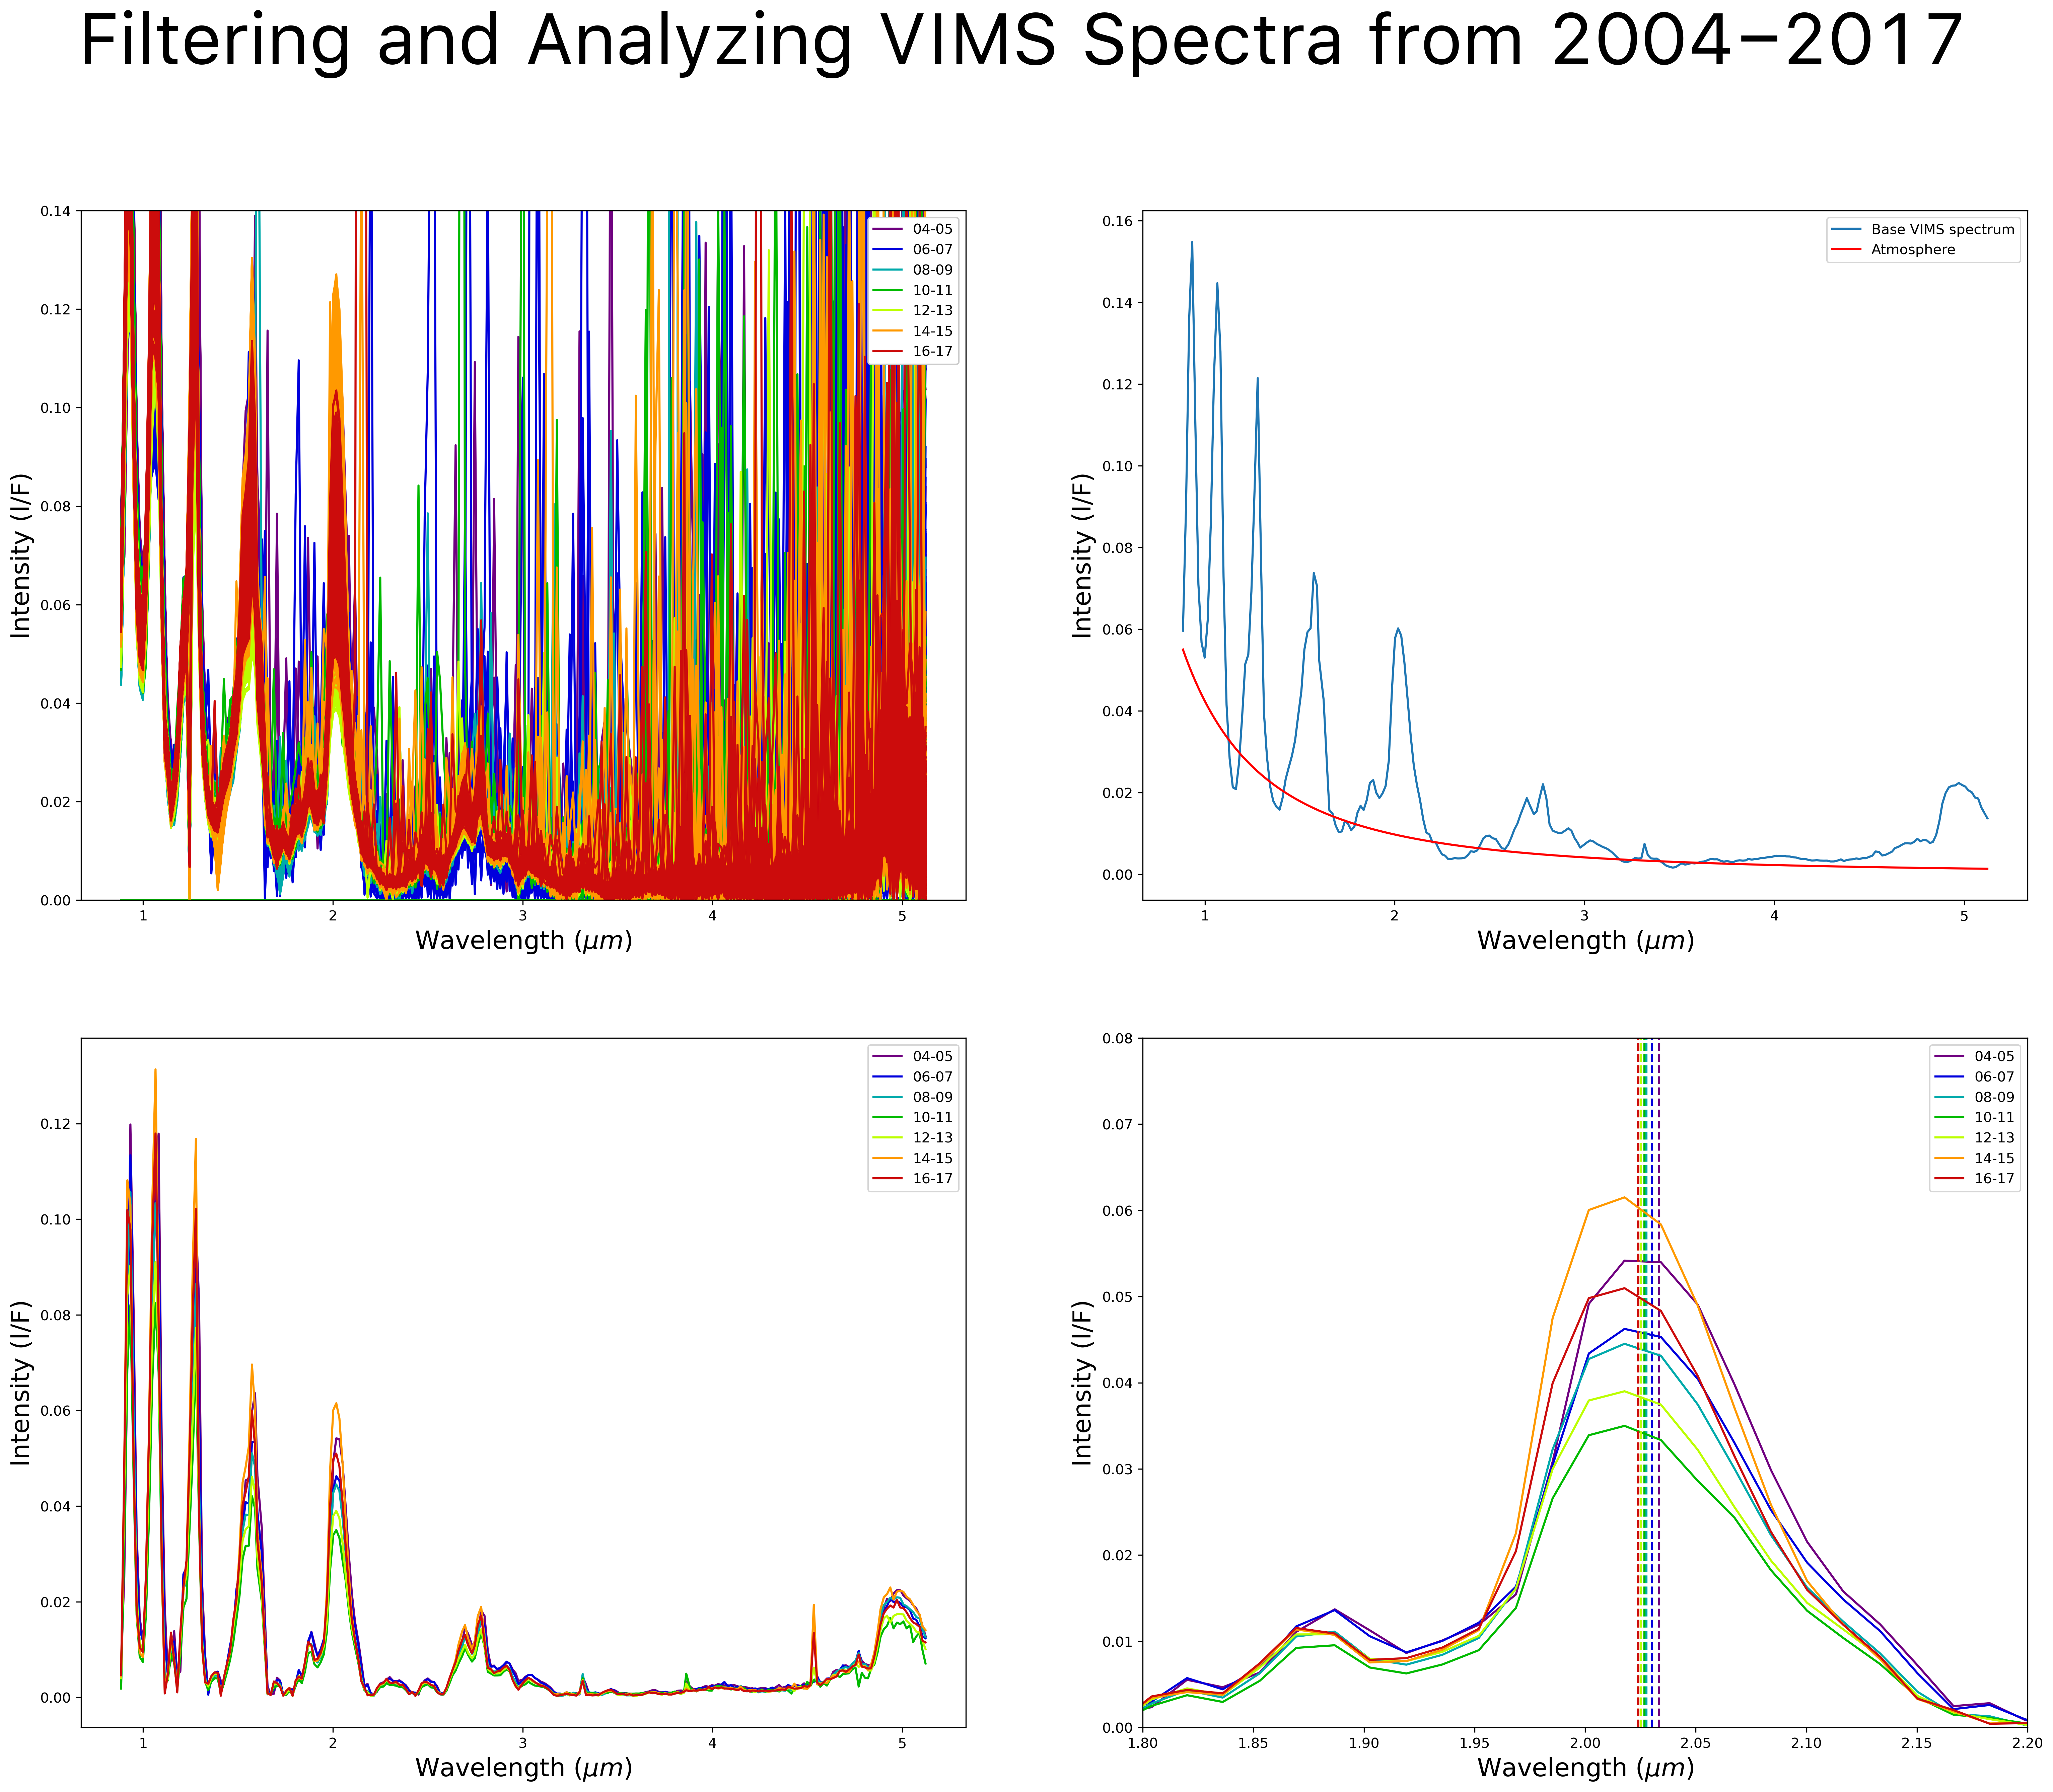

In [3]:
# Four part figure (panels a,b,c,d)
%matplotlib inline
fig,axs = plt.subplots(2,2,figsize=(25,20),facecolor='white',dpi=300)
fig.suptitle('Filtering and Analyzing VIMS Spectra from 2004-2017',fontname='.Keyboard',fontweight='bold',fontsize=50)

#Font Sizes and other attributes
size = 18
color = plt.cm.nipy_spectral(np.linspace(0.05,0.95,7))

#Figure 2A
for list,c,number in zip(spec_list,color,new_array):
    string = number[1:3]+'-'+number[3:5]
    for i in range(len(list)):
        if i == 0:
            axs[0,0].plot(vims_wave,list[i],c=c,label=string)
        else:
            axs[0,0].plot(vims_wave,list[i],c=c)
axs[0,0].legend(loc='upper right',facecolor='white',framealpha=1)
axs[0,0].set_xlabel('Wavelength ($\mu m$)',fontsize=size)
axs[0,0].set_ylabel('Intensity (I/F)',fontsize=size)
axs[0,0].set_ylim([0,0.14])

#Figure 2B
atmos = fit_average(averaged_total) # Powerlaw fit function in cell 1
axs[0,1].plot(vims_wave,averaged_total,label='Base VIMS spectrum')
axs[0,1].plot(vims_wave,atmos,c='r',label='Atmosphere')
axs[0,1].legend()
axs[0,1].set_xlabel('Wavelength ($\mu m$)',fontsize=size)
axs[0,1].set_ylabel('Intensity (I/F)',fontsize=size)

#Figure 2c
for group,c,number in zip(pList_total,color,new_array):
    spectrum = np.average(np.asarray(group),axis=0)
    string = number[1:3]+'-'+number[3:5]
    axs[1,0].plot(vims_wave,spectrum,c=c,label=string)
axs[1,0].legend()
axs[1,0].set_xlabel('Wavelength ($\mu m$)',fontsize=size)
axs[1,0].set_ylabel('Intensity (I/F)',fontsize=size)



#Figure 2D
for group,c,number in zip(pList_total,color,new_array):
    spectrum = np.average(np.asarray(group),axis=0)
    string = number[1:3]+'-'+number[3:5]
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.025,.05])
    axs[1,1].plot(vims_wave,spectrum,c=c,label=string)
    axs[1,1].axvline(x=my_fit[1],c=c,linestyle='--')
axs[1,1].legend()
axs[1,1].set_xlim([1.8,2.2])
axs[1,1].set_xlabel('Wavelength ($\mu m$)',fontsize=size)
axs[1,1].set_ylim([0,.08])
axs[1,1].set_ylabel('Intensity (I/F)',fontsize=size)

plt.show()